# Computer Vision Play
Some code I wrote to support a couple of presentations on the topic of neural networks. This code allows you to play around with feeding random noise to neural networks and observing the classification results. This allows for looking at some basic statistics as well as using some model interpretability visualizations. For the visualizations I'm using [Captum](https://captum.ai/) a model interpretability framework for PyTorch.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F

from PIL import Image
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [3]:
# Check to see if cuda is avalable and set it to device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def gen_image():
    """ Generate an image of size 256 x 256 of random noise and return it in PIL format """
    
    image = (np.random.standard_normal([256, 256, 3]) * 255).astype(np.uint8)
    im = Image.fromarray(image)
    
    return im    

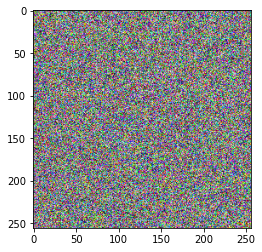

In [11]:
# Generate a single image and display the result
result = gen_image()
plt.imshow(result)

In [12]:
# Create label mapping for imagenet classes
with open("imagenet_class_index.json") as json_data:
    idx_to_labels = json.load(json_data)

In [13]:
def xform_image(image):
    """ Perform image transformations on a single image to feed into the model for testing purposes """
    
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    
    new_image = transform(image).to(device)
    new_image = new_image.unsqueeze_(0)
    
    return new_image

In [14]:
# Instantiate VGG16
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
vgg16.to(device);

In [15]:
# Instantiate Resnet 
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()
resnet18.to(device);

In [16]:
# Instantiate Alexnet
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
alexnet.to(device);

In [17]:
# Instantiate densenet
densenet = models.densenet161(pretrained=True)
densenet.eval()
densenet.to(device);

In [18]:
# Instantiate inception
inception = models.inception_v3(pretrained=True)
inception.eval()
inception.to(device);

In [19]:
def multi_predict(image_xform):
    """ Run the selected image through multiple pre-trained networks """
    
    result = {}
    
    with torch.no_grad():
        vgg16_res = vgg16(image_xform)
        result.update({"vgg16": vgg16_res})
        
        res18_res = resnet18(image_xform)
        result.update({"resnet18": res18_res})
        
        alex_res = alexnet(image_xform)
        result.update({"alexnet": alex_res})
        
        dense_res = densenet(image_xform)
        result.update({"densenet": dense_res})
        
        incept_res = inception(image_xform)
        result.update({"inception": incept_res})
        
    return result

# Multi-image
This section provides generation and processing for multiple images. It also sets up a dataframe for analyzing results.

In [20]:
# Create dataframe to hold results. Move this outside the block to maintain results over multiple runs 
df = pd.DataFrame(columns=["imageID", "vgg16label", "vgg16pred", "resnet18label", "resnet18pred", "alexnetlabel", "alexnetpred",
                          "densenetlabel", "densenetpred", "inceptionlabel", "inceptionpred"])

# Perform testing on a specified number of generated images
number = 1000

counter = 1

for item in range(number):
    
    image = gen_image()
    image_xform = xform_image(image)
    result = multi_predict(image_xform)
    
    # vgg16 
    vgg16_output = F.softmax(result["vgg16"], dim=1)
    vgg16score, pred_label_idx = torch.topk(vgg16_output, 1)
    vgg16label = idx_to_labels[str(pred_label_idx.item())][1]

    # resnet18
    resnet18_output = F.softmax(result["resnet18"], dim=1)
    resnet18score, pred_label_idx = torch.topk(resnet18_output, 1)
    resnet18label = idx_to_labels[str(pred_label_idx.item())][1]

    # alexnet
    alexnet_output = F.softmax(result["alexnet"], dim=1)
    alexnetscore, pred_label_idx = torch.topk(alexnet_output, 1)
    alexnetlabel = idx_to_labels[str(pred_label_idx.item())][1]

    # densenet
    densenet_output = F.softmax(result["densenet"], dim=1)
    densenetscore, pred_label_idx = torch.topk(densenet_output, 1)
    densenetlabel = idx_to_labels[str(pred_label_idx.item())][1]

    # inception 
    inception_output = F.softmax(result["inception"], dim=1)
    inceptionscore, pred_label_idx = torch.topk(inception_output, 1)
    inceptionlabel = idx_to_labels[str(pred_label_idx.item())][1]
    
    imageID = "image" + str(counter)
    
    new_row = {"imageID": imageID, "vgg16label": vgg16label, "vgg16pred": vgg16score.squeeze().item(), 
               "resnet18label": resnet18label, "resnet18pred": resnet18score.squeeze().item(), 
               "alexnetlabel": alexnetlabel, "alexnetpred": alexnetscore.squeeze().item(), 
               "densenetlabel": densenetlabel, "densenetpred": densenetscore.squeeze().item(), 
               "inceptionlabel": inceptionlabel, "inceptionpred": inceptionscore.squeeze().item()}
    
    # Does the job for simple tests  
    df = df.append(new_row, ignore_index=True)
    
    counter += 1

In [49]:
# Display the first 5 rows of the dataframe
# df.head()

In [21]:
# Display statistics for the 5 models
df.describe()

,vgg16pred,resnet18pred,alexnetpred,densenetpred,inceptionpred
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.226978,0.328249,0.147289,0.409413,0.020204
std,0.067972,0.071808,0.038628,0.148315,0.016490
min,0.074922,0.127953,0.061019,0.139161,0.005963
25%,0.178240,0.278830,0.120568,0.291042,0.011641
50%,0.223623,0.324111,0.143090,0.387705,0.015880
75%,0.270547,0.373325,0.171139,0.511357,0.022519
max,0.438011,0.580559,0.328568,0.868025,0.198698


In [22]:
# Get value counts of a specified prediction from a model.
print("Vgg16 Results:")
print(df["vgg16label"].value_counts(), "\n")
print("Resnet18 Results:")
print(df["resnet18label"].value_counts(), "\n")
print("Alexnet Results:")
print(df["alexnetlabel"].value_counts(), "\n")
print("Densenet Results:")
print(df["densenetlabel"].value_counts(), "\n")
print("Inception Results:")
print(df["inceptionlabel"].value_counts())

Vgg16 Results:
stole         978
jellyfish      14
coral_reef      7
poncho          1
Name: vgg16label, dtype: int64 

Resnet18 Results:
jellyfish    1000
Name: resnet18label, dtype: int64 

Alexnet Results:
poncho     942
dishrag     58
Name: alexnetlabel, dtype: int64 

Densenet Results:
chainlink_fence    893
window_screen       37
chain_mail          33
doormat             20
tile_roof           16
space_heater         1
Name: densenetlabel, dtype: int64 

Inception Results:
switch               155
magpie               123
jigsaw_puzzle        102
pillow                85
jean                  83
indigo_bunting        81
birdhouse             69
honeycomb             32
poncho                26
carton                25
mousetrap             24
sarong                18
corn                  16
chain_mail            16
vacuum                12
window_screen         12
cardigan              11
American_egret         9
broccoli               9
wallet                 8
sandbar        

# Single Image
The code below allows for generation and processing of a single image

vgg16: stole, Score: 0.2295
resnet18: jellyfish, Score: 0.4038
alexnet: poncho, Score: 0.1075
densenet: chainlink_fence, Score: 0.3166
inception: nail, Score: 0.0151


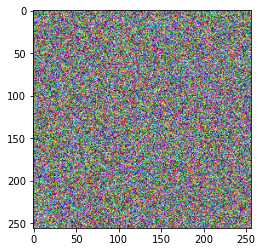

In [23]:
# Generate a new image from random noise
image = gen_image()

# Choose a real Image instead of a generated one for comparison. Specify location in path. 
# image = Image.open("images/something.jpg")

image_xform = xform_image(image)

result = multi_predict(image_xform)

# Test REMOVE LATER
result.update({"imageID": "image_xform"})

# Print results for a single run from each of the models
# vgg16 
vgg16_output = F.softmax(result["vgg16"], dim=1)
vgg16score, pred_label_idx = torch.topk(vgg16_output, 1)
vgg16label = idx_to_labels[str(pred_label_idx.item())][1]

# resnet18
resnet18_output = F.softmax(result["resnet18"], dim=1)
resnet18score, pred_label_idx = torch.topk(resnet18_output, 1)
resnet18label = idx_to_labels[str(pred_label_idx.item())][1]

# alexnet
alexnet_output = F.softmax(result["alexnet"], dim=1)
alexnetscore, pred_label_idx = torch.topk(alexnet_output, 1)
alexnetlabel = idx_to_labels[str(pred_label_idx.item())][1]

# densenet
densenet_output = F.softmax(result["densenet"], dim=1)
densenetscore, pred_label_idx = torch.topk(densenet_output, 1)
densenetlabel = idx_to_labels[str(pred_label_idx.item())][1]

# inception 
inception_output = F.softmax(result["inception"], dim=1)
inceptionscore, pred_label_idx = torch.topk(inception_output, 1)
inceptionlabel = idx_to_labels[str(pred_label_idx.item())][1]


# print(vgg16label)
# print(vgg16score.squeeze().item())

print(f"vgg16: {vgg16label}, Score: {vgg16score.squeeze().item():.4f}")
print(f"resnet18: {resnet18label}, Score: {resnet18score.squeeze().item():.4f}")
print(f"alexnet: {alexnetlabel}, Score: {alexnetscore.squeeze().item():.4f}")
print(f"densenet: {densenetlabel}, Score: {densenetscore.squeeze().item():.4f}")
print(f"inception: {inceptionlabel}, Score: {inceptionscore.squeeze().item():.4f}")

plt.imshow(image)

# Visualization 
In this section an image can be fed through a specified model and visualized in a couple of different ways.

In [25]:
# Use a specified image otherwise use the previously generated image
# image = Image.open("images/something.jpg")
# image_xform = xform_image(image)

# Generate a new image in place of the previous
# image = gen_image()
# image_xform = xform_image()

# Choose an instantiated model and use the image was fed to the models
result = resnet18(image_xform)
result = F.softmax(result, dim=1)
score, pred_label_idx = torch.topk(result, 1)

integrated_gradients = IntegratedGradients(resnet18)
attributions_ig = integrated_gradients.attribute(image_xform, target=pred_label_idx, 
                                                 internal_batch_size=50, n_steps=200)

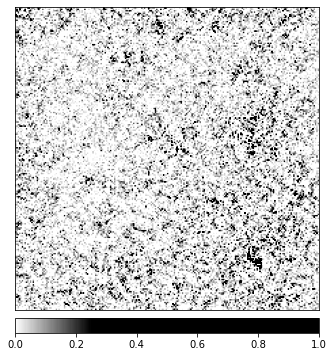

In [26]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image_xform.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


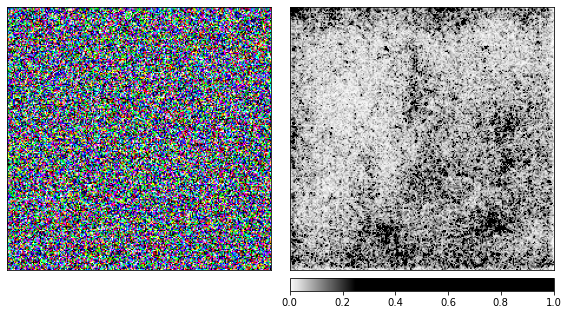

In [27]:
# Using a noise tunnel
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(image_xform, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, internal_batch_size=50)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_xform.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [28]:
# Using Occlusion
occlusion = Occlusion(resnet18)

attributions_occ = occlusion.attribute(image_xform,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


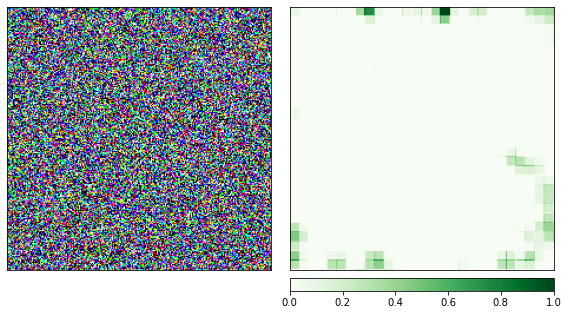

In [29]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_xform.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )